# Preparo da Base para Análise

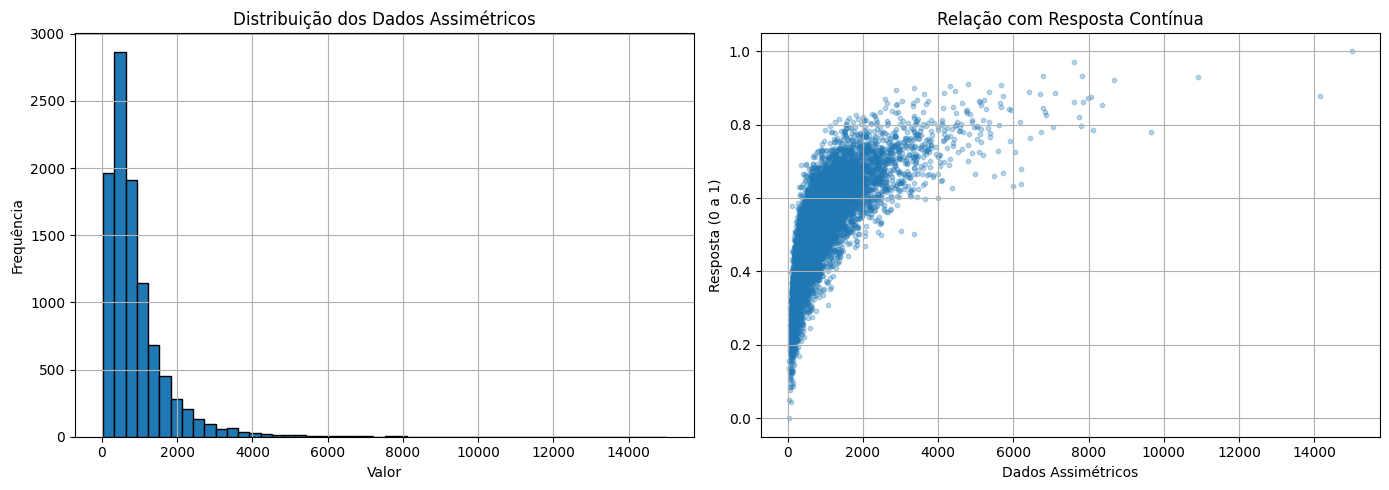

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir semente para reprodutibilidade
np.random.seed(42)

# Gerar dados com distribuição log-normal (assimétrica)
dados_brutos = np.random.lognormal(mean=8, sigma=0.8, size=10000)

# Escalar os dados para o intervalo de 0 a 15.000
dados_escala = dados_brutos / dados_brutos.max() * 15000

# Criar uma variável resposta contínua relacionada aos dados assimétricos
# Vamos simular uma relação não-linear e normalizar entre 0 e 1
resposta_raw = np.log1p(dados_escala) + np.random.normal(0, 0.5, size=len(dados_escala))
resposta_normalizada = (resposta_raw - resposta_raw.min()) / (resposta_raw.max() - resposta_raw.min())

# Criar DataFrame final
df = pd.DataFrame({
    'X': dados_escala,
    'y': resposta_normalizada
})

# Criar subplots: histograma e relação com variável resposta
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Histograma dos dados assimétricos
axs[0].hist(df['X'], bins=50, edgecolor='k')
axs[0].set_title('Distribuição dos Dados Assimétricos')
axs[0].set_xlabel('Valor')
axs[0].set_ylabel('Frequência')
axs[0].grid(True)

# Subplot 2: Dispersão entre variável original e resposta contínua
axs[1].scatter(df['X'], df['y'], alpha=0.3, s=10)
axs[1].set_title('Relação com Resposta Contínua')
axs[1].set_xlabel('Dados Assimétricos')
axs[1].set_ylabel('Resposta (0 a 1)')
axs[1].grid(True)

plt.tight_layout()
plt.show()



In [29]:
df.head(3)

,X,y
0,965.056489,0.511620
1,580.682348,0.467843
2,1088.946665,0.533620


# Categorização fixa (Fixed-Width Binning)

In [59]:
# Criar faixas de 1000 em 1000
bins = np.arange(0, 16000, 1000)  # vai até 15000 (inclusive)

# Categorizar com pd.cut
df['fixed_width_binning'] = pd.cut(df['X'], bins=bins, right=False, include_lowest=True)

df.head()

,X,y,fixed_width_binning,percentil_binning
0,965.056489,0.511620,"[0, 1000)","(792.103, 1269.418]"
1,580.682348,0.467843,"[0, 1000)","(529.891, 792.103]"
2,1088.946665,0.533620,"[1000, 2000)","(792.103, 1269.418]"
3,2193.468149,0.677410,"[2000, 3000)","(1269.418, 15000.0]"
4,537.803158,0.559922,"[0, 1000)","(529.891, 792.103]"


In [60]:
# Há problema que determinadas faixas tem poucos dados, o que pode dificultar o processo de modelagem
df['fixed_width_binning'].value_counts()

fixed_width_binning
[0, 1000)         7082
[1000, 2000)      2113
[2000, 3000)       527
[3000, 4000)       160
[4000, 5000)        58
[5000, 6000)        31
[6000, 7000)        12
[7000, 8000)         9
[8000, 9000)         4
[9000, 10000)        1
[10000, 11000)       1
[14000, 15000)       1
[11000, 12000)       0
[12000, 13000)       0
[13000, 14000)       0
Name: count, dtype: int64

# Categorização por Quantis (Quantile Binning)

In [41]:
df['percentil_binning'] = pd.qcut(df['X'], q=5)

df.head()

,X,y,fixed_width_binning,percentil_binning
0,965.056489,0.511620,"[0, 1000)","(792.103, 1269.418]"
1,580.682348,0.467843,"[0, 1000)","(529.891, 792.103]"
2,1088.946665,0.533620,"[1000, 2000)","(792.103, 1269.418]"
3,2193.468149,0.677410,"[2000, 3000)","(1269.418, 15000.0]"
4,537.803158,0.559922,"[0, 1000)","(529.891, 792.103]"


In [42]:
# Todas as faixas possuem a mesma quantidade de dados
df['percentil_binning'].value_counts()

percentil_binning
(28.131, 330.054]      2000
(330.054, 529.891]     2000
(529.891, 792.103]     2000
(792.103, 1269.418]    2000
(1269.418, 15000.0]    2000
Name: count, dtype: int64

In [50]:
df.groupby('percentil_binning', observed=False)['y'].agg(mean_y='mean')

,mean_y
percentil_binning,
"(28.131, 330.054]",0.352546
"(330.054, 529.891]",0.447681
"(529.891, 792.103]",0.504115
"(792.103, 1269.418]",0.560070
"(1269.418, 15000.0]",0.658225


In [ ]:
# ANOVA (Análise de Variância)
from scipy.stats import f_oneway
# Suponha que você tenha categorizado X em 'faixa_X'
grupos = [df[df['percentil_binning'] == cat]['y'] for cat in df['percentil_binning'].unique()]
f_stat, p_valor = f_oneway(*grupos)

print(f"Valor-p: {p_valor}")

Valor-p: 0.0


In [ ]:
# Teste de Kruskal-Wallis (não paramétrico, mais robusto)
from scipy.stats import kruskal

grupos = [df[df['percentil_binning'] == cat]['y'] for cat in df['percentil_binning'].unique()]
estatistica, p_valor = kruskal(*grupos)

print(f"Valor-p: {p_valor}")


Valor-p: 0.0


In [74]:
# Obter as categorias ordenadas
categorias = df['percentil_binning'].cat.categories

# Aplicar o teste de Kruskal-Wallis entre faixas adjacentes
resultados = []

for i in range(len(categorias) - 1):
    cat1 = categorias[i]
    cat2 = categorias[i + 1]

    grupo1 = df[df['percentil_binning'] == cat1]['y']
    grupo2 = df[df['percentil_binning'] == cat2]['y']

    estatistica, p_valor = kruskal(grupo1, grupo2)

    resultados.append({
        'faixa_1': str(cat1),
        'faixa_2': str(cat2),
        'p_valor': p_valor
    })

# Converter em DataFrame para visualização
df_resultados = pd.DataFrame(resultados)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Resultados Kruskal-Wallis por Pares de Faixas", dataframe=df_resultados)


In [75]:
df_resultados

,faixa_1,faixa_2,p_valor
0,"(28.131, 330.054]","(330.054, 529.891]",5.031942e-249
1,"(330.054, 529.891]","(529.891, 792.103]",1.980234e-125
2,"(529.891, 792.103]","(792.103, 1269.418]",5.959911e-119
3,"(792.103, 1269.418]","(1269.418, 15000.0]",2.462028e-258


In [ ]:
# Script para combinar as faixas de forma iterativa
i = 0
while i < len(faixas):
    if i == len(faixas) - 1:
        grupos_final.append([faixas[i]])
        break

    cat1 = faixas[i]
    cat2 = faixas[i + 1]

    grupo1 = df[df['faixa_X'] == cat1]['resposta_continua']
    grupo2 = df[df['faixa_X'] == cat2]['resposta_continua']

    estatistica, p_valor = kruskal(grupo1, grupo2)

    if p_valor >= 0.05:
        # Combinar as faixas
        novo_grupo = [cat1, cat2]
        i += 2

        # Verificar se já havia grupo anterior combinado
        while i < len(faixas):
            grupo_extra = df[df['faixa_X'] == faixas[i]]['resposta_continua']
            estatistica, p_valor = kruskal(grupo1.append(grupo2), grupo_extra)

            if p_valor < 0.05:
                break
            novo_grupo.append(faixas[i])
            grupo2 = grupo2.append(grupo_extra)
            i += 1

        grupos_final.append(novo_grupo)
    else:
        grupos_final.append([cat1])
        i += 1

# Criar novo mapeamento de faixa combinada
faixa_mapeada = {}
for idx, grupo in enumerate(grupos_final):
    nome = f"Grupo_{idx+1}"
    for faixa in grupo:
        faixa_mapeada[str(faixa)] = nome

# Aplicar nova categorização ao DataFrame
df['faixa_combinada'] = df['faixa_X'].astype(str).map(faixa_mapeada)

import ace_tools as tools; tools.display_dataframe_to_user(name="DataFrame com Faixas Combinadas", dataframe=df)

# Transformação Logarítimica